## Ziele
Festlegung der Zielgroesse: PCR Platte, spezifisch, wird in kontaminierte Platte (Platte 1) und nicht kontaminierte Platte unterschieden. Ziel ist es mit einem ueberwachtem Lernverfahren vorherzusagen, ob eine Platte kontaminiert sein wird.
Falls das mit annehmbarer Accuracy vorherzusagen ist, interessieren mich vor Allem die Features, die wichtig fuer die Vorhersage sind. Daraus erhoffe ich mir herauszufinden welche Variablen fuer die Kontamination verantwortlich sind / waren. Es handelt sich um eine Klassifikationsaufgabe

## Ziele Bullet Points
* What went wrong with the contaminated PCR Plate
* Can we predict the contaminated PCR Plate
* Are there specific contaminations

## Implementation
* Use Random Forest to predict PCR Plate (1 and other)
* Check Accuracy
- Use RF Feature Importance to find factors that contribute to contamination
- Use Shapley Value to find factors that contribute to contamination

### TO DO
* Use different target variable such as Nano Drop value for contamination
* Use Notes to classifie contamination
- Include richness / eveness as feature
- Any other cool ideas that come across my mind

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import shap

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

import pandas as pd
import numpy as np
np.random.seed(0)



%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

In [2]:
# read data
df = pd.read_csv("../data/output/preprocessed_data.csv",  index_col=0)

In [3]:

# Modify target variable
df = df.assign(
    is_contamined = lambda dataframe: dataframe['PCR_plate'].map(lambda PCR_plate: 1 if PCR_plate == 1 else 0) 
)
df = df.drop(columns=["PCR_plate"])

In [4]:
df.is_contamined

100A    0
100B    1
101A    1
101B    0
103A    0
       ..
S6      1
S60     1
S7      1
S8      1
S9      1
Name: is_contamined, Length: 173, dtype: int64

## Task one split data in test and validation data
Therefore I use a custom function to have balanced classes, as mentioned before my target variable ist if the plate was contaminied

In [5]:
def split_to_train_test(df, label_column, train_frac=0.8):
    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    labels = df[label_column].unique()
    for lbl in labels:
        lbl_df = df[df[label_column] == lbl]
        lbl_train_df = lbl_df.sample(frac=train_frac)
        lbl_test_df = lbl_df.drop(lbl_train_df.index)
        print('\n%s:\n---------\ntotal:%d\ntrain_df:%d\ntest_df:%d' % (lbl, len(lbl_df), len(lbl_train_df), len(lbl_test_df)))
        train_df = train_df.append(lbl_train_df)
        test_df = test_df.append(lbl_test_df)

    return train_df, test_df

In [6]:
train_df, test_df = split_to_train_test(df, "is_contamined",0.7)


0:
---------
total:90
train_df:63
test_df:27

1:
---------
total:83
train_df:58
test_df:25


In [7]:
# Check Class Balance to select suitable evaluation metric
df.is_contamined.value_counts()

0    90
1    83
Name: is_contamined, dtype: int64

## Task 2: Select a evaluation metric
For my first analyses I will chose the Accuracy as defined: Accuracy = (TP+TN)/(TP+FP+FN+TN) as a metric. It is a well established metric for a two class classification problem and since we have equally balanced classes it is a reasonable choice

## Task 3: Create a baseline model
Since I have a two class classification problem with balanced classes, it is suitable to chose the relative frequency of the more frequent class as naive baseline prediction accuracy.


In [8]:
# baseline estimation
freq_class = max(df.is_contamined.value_counts())
baseline = freq_class / len(df.index)
print("Baseline Estimation ${}".format(baseline))

Baseline Estimation $0.5202312138728323


## Task 4: Use a supervised machine learning model
My goal is mainly to find features 

In [9]:
# prepare data for Random forest

# test target variable
test_Y = test_df.is_contamined
# test independent variables
test_X = test_df.drop(columns=["is_contamined"])

# train target variable
train_Y = train_df.is_contamined
# test independent variables
train_X = train_df.drop(columns=["is_contamined"])
rf = RandomForestClassifier(n_estimators=200)
fit = rf.fit(train_X, train_Y)


In [10]:
# predict
predictions = fit.predict(test_X)

In [11]:
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

[[26  1]
 [ 0 25]]


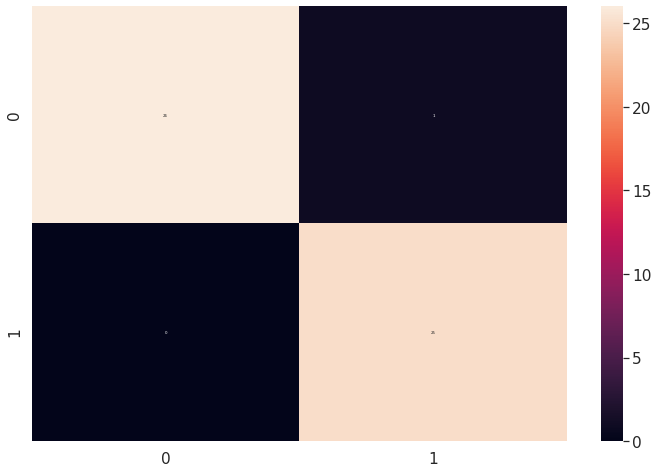

In [22]:
# checking accuracy
# len(trani)
conf_mat = confusion_matrix(test_df.is_contamined, predictions)
print(conf_mat)
conf_mat


df_cm = pd.DataFrame(conf_mat, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 4}) # font size

plt.show()

In [13]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_Y, predictions))

Accuracy: 0.9807692307692307


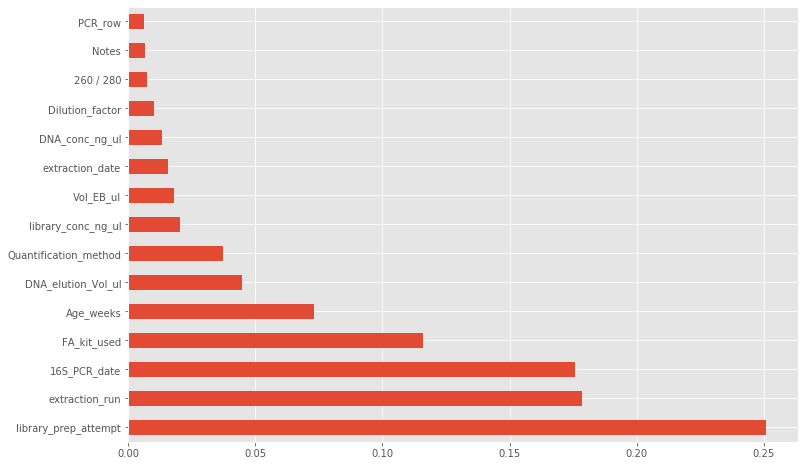

In [14]:
feat_importances = pd.Series(rf.feature_importances_, index=df.drop(columns=["is_contamined"]).columns)
feat_importances.nlargest(15).plot(kind='barh')

In [15]:
df.describe()

,Rearing_LAB,Age_weeks,sample_type,extraction_date,extraction_run,extracted_by,DNA_elution_Vol_ul,Quantification_method,DNA_conc_ng_ul,260 / 280,...,water_chlorinated,mean_room_temp_C,room_humidity,other_animals_present,other_animals_present_kind,housing_room_condition,tail_handling,Notes,median_count,is_contamined
count,173.000000,173.000000,173.0,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,...,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.0,173.000000
mean,2.046243,11.953757,0.0,5.809249,9.502890,0.965318,160.346821,0.485549,199.517514,1.900462,...,0.208092,1.439306,1.803468,0.791908,1.942197,0.208092,0.791908,1.450867,0.0,0.479769
std,1.413453,2.852610,0.0,3.700020,6.049817,0.969871,32.095351,0.501242,84.799128,0.035745,...,0.407122,1.019042,1.154662,0.407122,1.413025,0.407122,0.407122,3.214097,0.0,0.501041
min,0.000000,8.000000,0.0,0.000000,1.000000,0.000000,100.000000,0.000000,28.800000,1.830000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,1.000000,8.000000,0.0,2.000000,4.000000,0.000000,160.000000,0.000000,142.000000,1.880000,...,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000
50%,2.000000,14.000000,0.0,7.000000,9.000000,1.000000,160.000000,0.000000,202.820000,1.890000,...,0.000000,1.000000,2.000000,1.000000,2.000000,0.000000,1.000000,0.000000,0.0,0.000000
75%,3.000000,14.000000,0.0,9.000000,15.000000,2.000000,200.000000,1.000000,255.900000,1.910000,...,0.000000,2.000000,3.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.0,1.000000
max,4.000000,14.000000,0.0,11.000000,20.000000,2.000000,240.000000,1.000000,418.000000,2.050000,...,1.000000,3.000000,3.000000,1.000000,4.000000,1.000000,1.000000,11.000000,0.0,1.000000


In [16]:
df.iloc[1:10,10]



100B    1.35
101A    1.93
101B    0.59
103A    2.01
103B    1.78
106A    1.42
106B    0.29
107A    0.85
107B    1.55
Name: 230 / 260, dtype: float64

## Shapley Value for feature contribution
// TODO describe


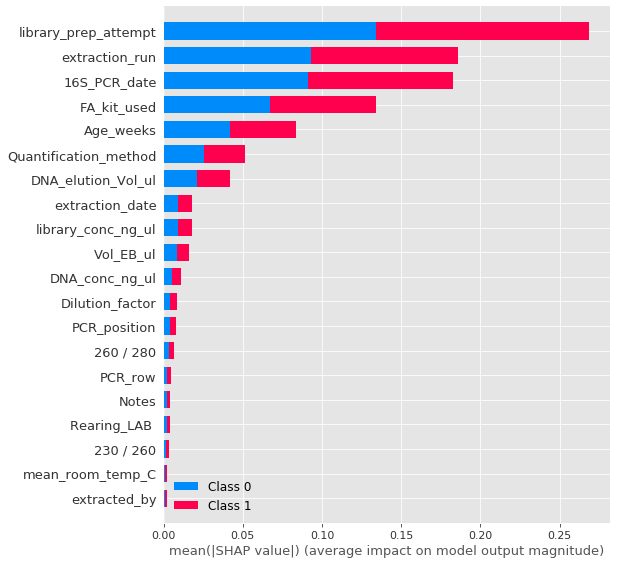

In [17]:
shap_values = shap.TreeExplainer(fit).shap_values(train_X)
shap.summary_plot(shap_values, train_X)

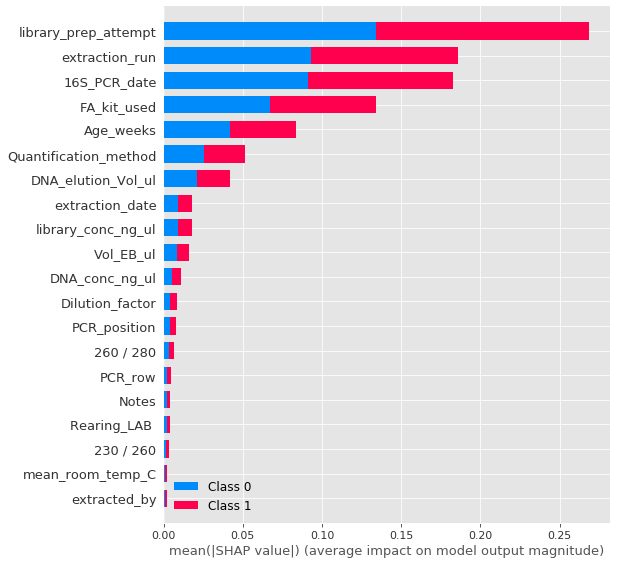

## Task 4.1 
### Use antoher targert variable for contamination
So far I have only used the plate as target variable to get predict